# Automatic Feature Extraction in Convolution Neural Networks vs Manual Feature Extraction: Can Manual Feature Extraction outperform CNN's?

With CNNs being able to extract features from an input image (pixel dependencies etc.), are manual feature extraction methods obsolete? According to [this](https://datascience.stackexchange.com/questions/62409/is-manual-feature-extraction-outdated) stackexchange thread, it is not. We will test CNNs on image data and compare the results with using manual feature extraction (Grayscale values, mean channel value, edge detection) in combination with a more traditional ML algorithm: Decision trees.

We are especially interested in:
- The difference between E_in and E_out per method, as datasets with huge amount of features (such as images) might lead to model overfitting
- Differences between the errors of both methods
- To what extent is manual feature extraction still relevant in the case of image classification?
- What is the impact of different feature extraction techniques on model performance?

In [169]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D ,Input, InputLayer, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from skimage import filters, feature

import tensorflow as tf
import pandas as pd
import numpy as np


## Image data
Dataset is from [kaggle](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images). It is an image classification problem with 3 classes: boot, sandal, shoe. It consists of 15k samples (5k samples of each class). The images are in RGB and of size 128x128. The orientation of all footwear in the dataset is the same, as well as the background (white). This should result in the models being able to learn without any image augmentation and still get high accuracy on the validation/test set. 

In [2]:
batch_size = 32
img_height = 128
img_width = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)
print(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.
['Boot', 'Sandal', 'Shoe']


## Convolutional Neural Network

We will use the same network architecture used for 1.6. The algorithm is explained in the beginning of section 1.5. Due to the use of convolutional layers, the network will learn what features are important by itself only using the fact that neighbouring pixels have some codependence. This means that image samples can be fed as-is through the network.

We use early stopping. This means that the algorithm stops training if no improvement to the validation accuracy is made over a set amount of epochs.

In [3]:
EPOCHS = 100

data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2)
])

model = Sequential([
    Rescaling(1./255),
    data_augmentation,
    #InputLayer(input_shape = (128,128,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax') # use softmax because we have 3 classes instead of 2 (as in 1.7)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build((batch_size, img_height, img_width, 3))
#model.save_weights("shoemodel.h5")
model.load_weights('shoemodel.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 128, 128, 3)         0         
                                                                 
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 128, 128, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (32, 128, 128, 32)       128       
 hNormalization)                                      

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/100
375/375 [==============================] - 803s 2s/step - loss: 0.8659 - accuracy: 0.6409 - val_loss: 1.4428 - val_accuracy: 0.4340
Epoch 2/100
375/375 [==============================] - 784s 2s/step - loss: 0.5411 - accuracy: 0.7777 - val_loss: 3.2184 - val_accuracy: 0.4097
Epoch 3/100
375/375 [==============================] - 790s 2s/step - loss: 0.4217 - accuracy: 0.8347 - val_loss: 2.7795 - val_accuracy: 0.3960
Epoch 4/100
375/375 [==============================] - 779s 2s/step - loss: 0.3788 - accuracy: 0.8547 - val_loss: 1.6511 - val_accuracy: 0.3747
Epoch 5/100
375/375 [==============================] - 833s 2s/step - loss: 0.3449 - accuracy: 0.8688 - val_loss: 0.5662 - val_accuracy: 0.8037
Epoch 6/100
375/375 [==============================] - 706s 2s/step - loss: 0.2885 - accuracy: 0.8928 - val_loss: 4.1695 - val_accuracy: 0.3457
Epoch 7/100
375/375 [==============================] - 739s 2s/step - loss: 0.2704 - accuracy: 0.9008 - val_loss: 1.0304 - val_accuracy:

### Degree of generalization
The difference between in-sample and out-sample error corresponds to the difference between loss and val_loss (epoch 8) => |1 - 0.2466 - (1 - 0.2452)| = 0.0014. This shows that our model is able to generalize very well.

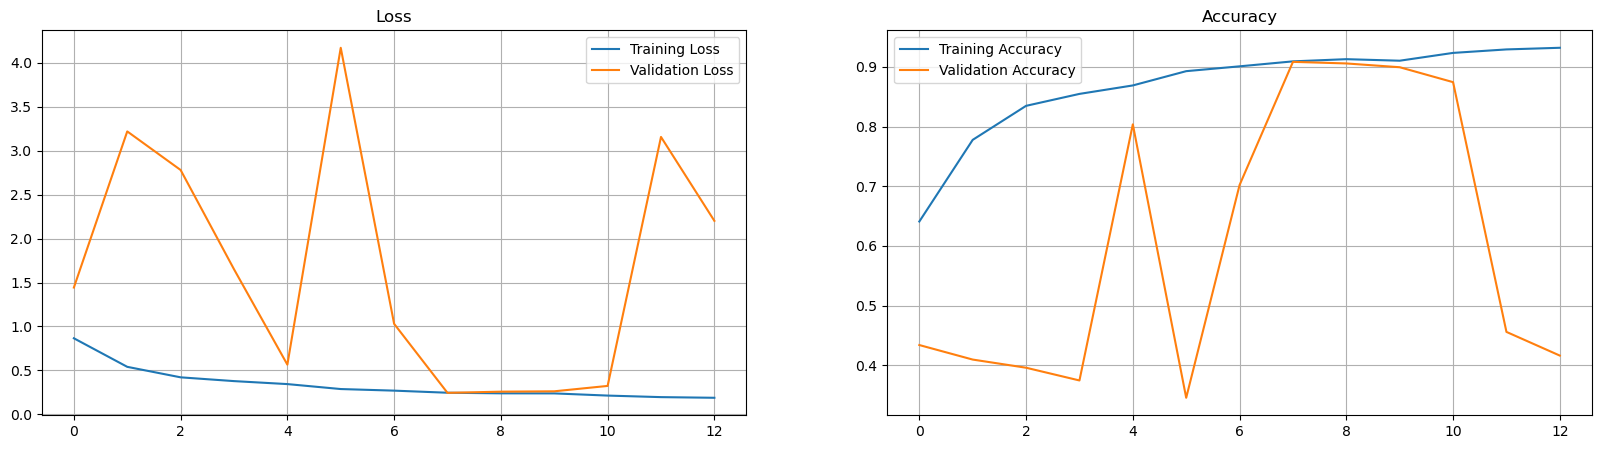

In [38]:
cnn_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(cnn_data.loss, label='Training Loss')
plt.plot(cnn_data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_data.accuracy, label='Training Accuracy')
plt.plot(cnn_data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

1/1 [==============================] - 0s 384ms/step
              precision    recall  f1-score   support

           0     0.9585    0.9528    0.9556      1017
           1     0.9479    0.8298    0.8849       987
           2     0.8329    0.9408    0.8835       996

    accuracy                         0.9083      3000
   macro avg     0.9131    0.9078    0.9080      3000
weighted avg     0.9133    0.9083    0.9084      3000



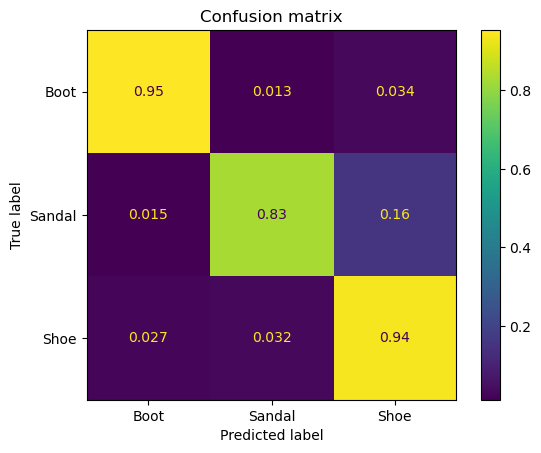

In [54]:
test_loss, test_accuracy = model.evaluate(val_ds)
accuracy = test_accuracy * 100

# slightly different functions as in 1.6 due to 3-class classification

def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')
    
    
def get_predictions_and_true_label(test_set, model):
    # iterate over the dataset
    y_pred = []
    for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
        # compute predictions
        preds = model.predict(image_batch)

        # append predicted labels
        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
        
    y_true = np.concatenate([y for x, y in test_set], axis=0)
    
    return y_true, y_pred

y_true, y_pred = get_predictions_and_true_label(val_ds, model)

report_data_image(y_pred, y_true)

1/1 [==============================] - 0s 288ms/step


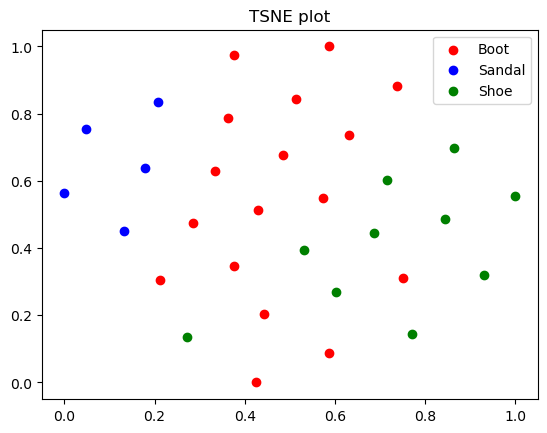

In [13]:
def TSNE_visualization_image(model, testX, title):
    

    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    y_pred = []
    for p, _ in testX.take(1): # Takes 1 batch
        features = model2(p)         # Predict 1 batch
        preds = model.predict(p)

        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
    
    labels = y_pred

    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):
        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range
    
    def shrink_vector(vector, max_val):
        replacement = []
        for i in vector:
            if i > max_val:
                break
            else:
                replacement.append(i)
        return replacement

    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue', 'green']
    classes = ["Boot" , "Sandal", "Shoe"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        indices = shrink_vector(indices, len(tx) - 1)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()



TSNE_visualization_image(model, val_ds, 'TSNE plot')

From our experiments it is clear that CNN is able to classify the dataset very well with a validation accuracy of around 90%. The performance could still be improved (to around [97%](https://www.kaggle.com/code/venkatganesh98/shoevsbootvssandal-classification-cnn-acc-97#4.Model-Building)), but our results suffice for a good baseline to compare against.

## Random forest classification

[motivation](https://ceur-ws.org/Vol-2320/short7.pdf)
### Feature extraction
Because our task is very simple image classifcation (no background, only the footwear in picture), we can resort to using edge detection for feature extraction.

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(3000, 16384)
(3000,)


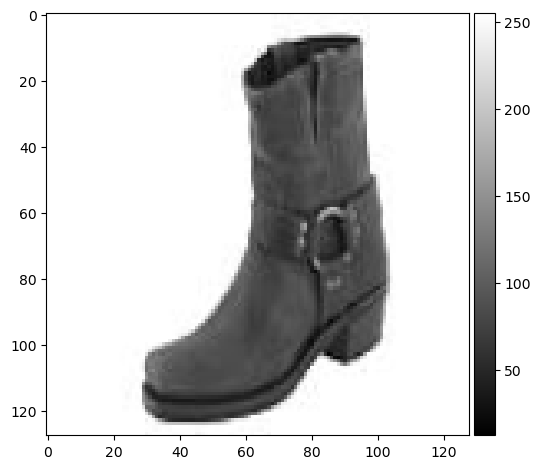

In [157]:
from skimage.io import imread, imshow

def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')

data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2)
])

  
# redefine datasets for use with sklearn filters => grayscale
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

def fetch_all(ds, filter=None, augmentation=None):
  imgs = []
  lbls = []
  for img, lbl in ds:
    if augmentation is not None:
      img = augmentation(img) # do this before reducing dimension to 2!
    img = img.numpy().squeeze()
    if filter is not None:
      img = filter(img)
    imgs.append(img.reshape(128*128)) # flatten the image into a vector
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(val_ds)
imgs, lbls = fetch_all(val_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)

## Raw data
First, we test a random forest model on the raw image data, just as with CNN.

              precision    recall  f1-score   support

           0     0.9277    0.9331    0.9304      1017
           1     0.8230    0.7822    0.8021       987
           2     0.8017    0.8363    0.8187       996

    accuracy                         0.8513      3000
   macro avg     0.8508    0.8506    0.8504      3000
weighted avg     0.8514    0.8513    0.8511      3000



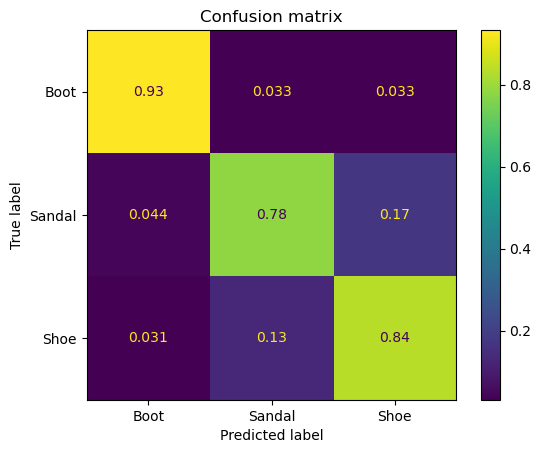

In [161]:
train_x, train_y = fetch_all(train_ds, augmentation = data_augmentation)
test_x, test_y = fetch_all(val_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
report_data_image(y_pred, test_y)

In [164]:
y_pred = rf_model.predict(train_x)
print(accuracy_score(train_y,y_pred))

1.0


The in-sample error is 0, while the out-sample error is 1-0.85. There is a slight difference between the two, it might indicate a case of slight overfitting. This was to be expected as there are large amount of features in the data. The relatively high score on the test set might be due to the uniformity of the pictures.

### Sobel kernel
The sobel kernel is a 3x3 filter that is often used in edge detection. It calculates the approximate gradient of the image intensity function by using two 3x3 kernels that convolve the original image (one for x-axis, one for y-axis).

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


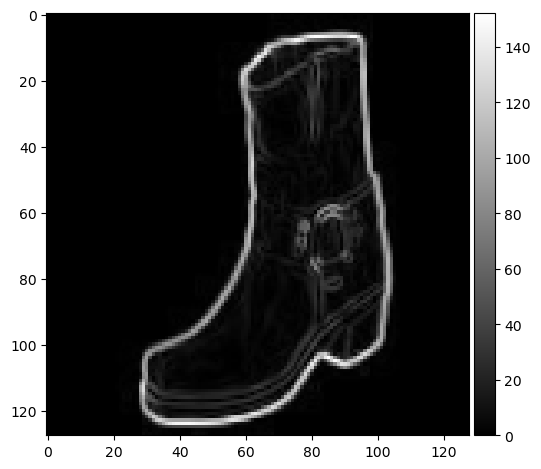

In [124]:
from skimage import filters

img, lbl = fetch_sample(val_ds)
sobel_img = filters.sobel(img)

imshow(sobel_img, cmap='gray')


In [122]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

RandomForestClassifier()

In [123]:
y_pred = rf_model.predict(test_x)
acc = accuracy_score(test_y, y_pred)

print('accuracy:', acc)

accuracy: 0.923


This accuracy is very good, even better than using a CNN. Although we have to consider the Randomflip and RandomRotation used to augment the dataset for the CNN (this is what will improve generalization to samples outside of the dataset):

In [128]:
train_x, train_y = fetch_all(train_ds, filters.sobel, data_augmentation)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

RandomForestClassifier()

In [145]:
y_pred = rf_model.predict(test_x)
acc = accuracy_score(test_y, y_pred)

print('accuracy:', acc)

# get a notion of the average tree depth for gridsearch
total = 0
for i in range(100):
    total += rf_model.estimators_[i].get_depth()
print(total/100)

accuracy: 0.8363333333333334
31.8


As expected, the classification accuracy has dropped. It is still not bad and we can improve upon this by using gridsearchCV to tune the randomforest hyperparameters:

In [146]:
train_x, train_y = fetch_all(train_ds, filters.sobel, data_augmentation)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
model = GridSearchCV(rf_model, {'n_estimators': [100, 128, 75], 'max_depth': [32, 50, 25]})

model.fit(train_x, train_y)
print(model.cv_results_)

{'mean_fit_time': array([ 83.33368974, 103.09451337,  61.26486006,  78.96186318,
       102.84778724,  59.56395493,  90.86221313, 101.74711833,
        69.46735168]), 'std_fit_time': array([3.75475997, 2.97875741, 1.24313894, 0.81809231, 2.28213565,
       0.49238377, 5.49509081, 4.49624882, 7.13553806]), 'mean_score_time': array([0.27218966, 0.28555498, 0.21536293, 0.24121413, 0.2790092 ,
       0.20507698, 0.26548214, 0.29075203, 0.29482784]), 'std_score_time': array([0.05189802, 0.00690199, 0.01222914, 0.01003193, 0.0062877 ,
       0.00741708, 0.02732633, 0.00821087, 0.1068893 ]), 'param_max_depth': masked_array(data=[32, 32, 32, 50, 50, 50, 25, 25, 25],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100, 128, 75, 100, 128, 75, 100, 128, 75],
             mask=[False, False, False, False, False, False, False, False,
                   Fal

accuracy: 0.8256666666666667
              precision    recall  f1-score   support

           0     0.8771    0.9263    0.9010      1017
           1     0.7960    0.7670    0.7812       987
           2     0.7979    0.7811    0.7894       996

    accuracy                         0.8257      3000
   macro avg     0.8237    0.8248    0.8239      3000
weighted avg     0.8241    0.8257    0.8246      3000



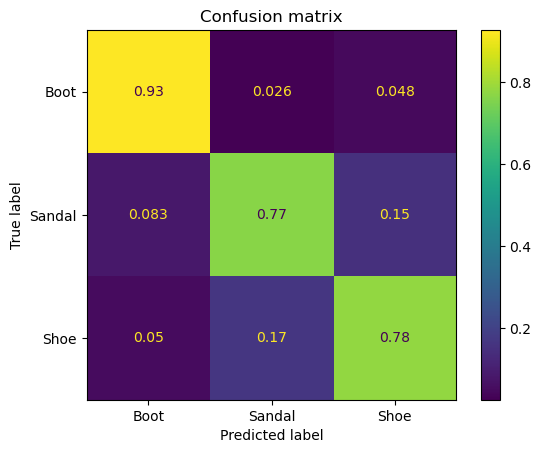

In [147]:
y_pred = model.predict(test_x)
acc = accuracy_score(test_y, y_pred)

print('accuracy:', acc)

report_data_image(y_pred, test_y)

We still get a test score of around 82% accuracy. When we compare E_in and E_out we get |1 - 0.8028 - (1 - 0.8257)| = 0.0229. The model does generalize pretty well to unseen data. It is also noticable that, just as with CNN, the model has highest misclassifications between shoes and sandals.

### Laplace operator
Another method for edge detection. In contrast to Sobel the 2nd derivative of the image intensity is computed. Instead of using 2 kernels it uses 1 symmetrical kernel. We investigate whether this impacts learning performance.


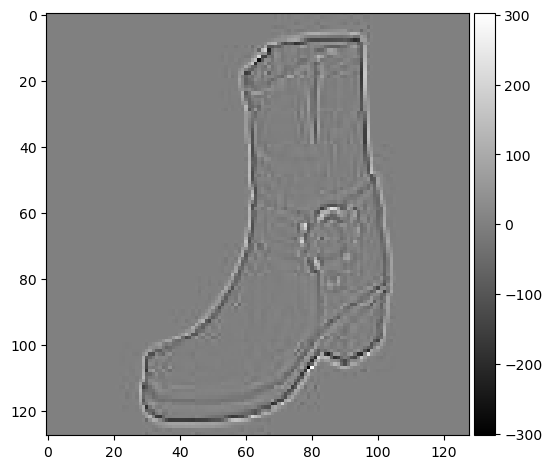

In [155]:
img, lbl = fetch_sample(val_ds)
img = filters.laplace(img)

imshow(img, cmap='gray')

{'mean_fit_time': array([ 82.69669003, 114.33776498,  71.86635957,  81.63016272,
       101.84042993,  59.50930419,  78.51433096, 105.34972734,
        63.94560242]), 'std_fit_time': array([2.7130408 , 8.04367417, 2.91776794, 2.3139775 , 1.05737691,
       0.31682468, 1.44395553, 7.61072884, 3.38509458]), 'mean_score_time': array([0.24889798, 0.32876363, 0.24184175, 0.25037808, 0.29369149,
       0.20441799, 0.24861574, 0.28971567, 0.23156629]), 'std_score_time': array([0.01151071, 0.03948751, 0.01953979, 0.0048078 , 0.0095557 ,
       0.00304853, 0.00673937, 0.0086448 , 0.04789346]), 'param_max_depth': masked_array(data=[32, 32, 32, 50, 50, 50, 25, 25, 25],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100, 128, 75, 100, 128, 75, 100, 128, 75],
             mask=[False, False, False, False, False, False, False, False,
                   Fal

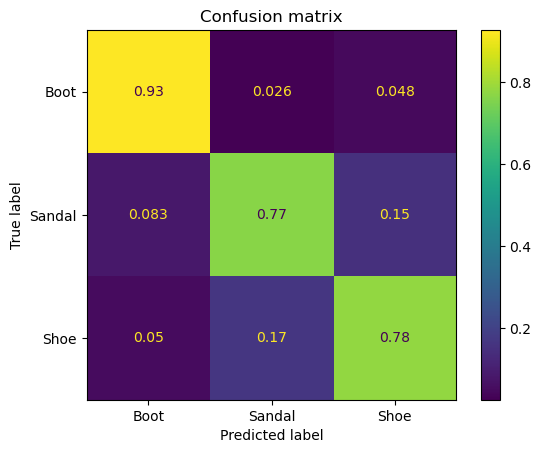

In [156]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2)
])
train_x, train_y = fetch_all(train_ds, filters.sobel, data_augmentation)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)
model = GridSearchCV(rf_model, {'n_estimators': [100, 128, 75], 'max_depth': [32, 50, 25]})

model.fit(train_x, train_y)
print(model.cv_results_)

report_data_image(y_pred, test_y)

We get very similar in-and-out-sample errors. The confusion matrices for both models are the same.

### Principal Component Analysis

The final feature extraction method we will investigate is principal component analysis [PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis). It is a dimensionality reduction method that benefits large datasets. It reduces the amount of features while retaining as much information as possible in the remaining features. The method works as follows:
- Standardize the input (feature) matrix D (subtract mean and divide by stdev)
- Calculate eigenvectors of the covariant matrix. We do this using sklearn's built-in PCA function. Call this matrix E.
    - The amount of eigenvectors we pick decides the amount of principal components we use
- We can reduce the data to P = D . E^T
- Train the model using P


In [170]:
# Use whole dataset to compute P, make splits later
ds = tf.keras.utils.image_dataset_from_directory(
  './data',
  validation_split=0,
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

D, lbls = fetch_all(ds)
D = (D - np.mean(D))/np.std(D)

pca = PCA()
print(D[0])
principalComponents = pca.fit_transform(D)
print(principalComponents[0])

Found 15000 files belonging to 3 classes.
[0.68428 0.68428 0.68428 ... 0.68428 0.68428 0.68428]
